In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata


In [29]:
import pandas as pd

# Ruta al archivo CSV
archivo_csv = 'promociones.csv'

# Leer el archivo CSV usando pandas
df = pd.read_csv(archivo_csv)


In [30]:
import spacy
from spacy.training import Example
from spacy.tokens import DocBin

In [45]:
#Tratamientos nulls

# Contar valores NaN en cada columna
na_counts = df.isna().sum()

# Mostrar el conteo de valores NaN
print(na_counts)

EAN NUEVO      0
DESCRIPCIÓN    0
Descuento      5
Mes            0
Categoria      0
dtype: int64


In [31]:
print(df.columns)
df.columns = df.columns.str.strip()
df = df.rename(columns={'Descuento ': 'Descuento'})

Index(['EAN NUEVO', 'DESCRIPCIÓN', 'Descuento ', 'Mes', 'Categoria'], dtype='object')


In [15]:
print(df.columns)

Index(['EAN NUEVO', 'DESCRIPCIÓN', 'Descuento', 'Mes', 'Categoria'], dtype='object')


In [32]:
#Reemplazo los NAs por el valor de la fila de arriba asumiendo que tiene el mismo valor

df['Descuento'] = df['Descuento'].fillna(method='ffill')


In [33]:
#Borro los EAN que tienen el "TODOS"

df = df[df['EAN NUEVO'] != 'TODOS']
df = df[df['EAN NUEVO'] != 'TODAS']

In [34]:
# Contar cuántas veces aparece cada combinación de 'EAN NUEVO' y 'Mes'
conteo_duplicados = df.groupby(['EAN NUEVO', 'Mes']).size()

# Filtrar las combinaciones que aparecen más de una vez
duplicados_count = conteo_duplicados[conteo_duplicados > 1]

# Mostrar el número de duplicados y las combinaciones duplicadas
print(f"Cantidad de combinaciones duplicadas: {len(duplicados_count)}")
print("Combinaciones duplicadas y su frecuencia:")
print(duplicados_count)


Cantidad de combinaciones duplicadas: 96
Combinaciones duplicadas y su frecuencia:
EAN NUEVO      Mes  
3600524057336  junio    2
4006000005478  julio    2
4006000005515  julio    2
650240068676   julio    2
7509546069609  julio    2
                       ..
7899706181839  junio    2
7899706181853  junio    3
7899706181877  junio    3
7899706188340  junio    3
8411300692000  junio    2
Length: 96, dtype: int64


In [35]:
#Contar cantidd de duplicados

# Contar la cantidad de duplicados basados en las columnas 'EAN NUEVO' y 'mes'
duplicados = df[df.duplicated(subset=['EAN NUEVO', 'Mes'], keep=False)]

# Mostrar el número de duplicados
print(f"Cantidad de filas duplicadas: {len(duplicados)}")

# Ver las combinaciones duplicadas
print(duplicados[['EAN NUEVO', 'Mes']].drop_duplicates())

Cantidad de filas duplicadas: 205
          EAN NUEVO     Mes
101   7793742007934  agosto
140   7793970136215  agosto
142   7793970136222  agosto
144   7793970136239  agosto
146   7793970136246  agosto
...             ...     ...
1289  4006000005478   julio
1403  7793970251017   julio
1405  7793970251208   julio
1407  7793970251505   julio
1803  7509552796131   julio

[96 rows x 2 columns]


In [36]:
#Elimino duplicados. Un duplicado es aquel que tiene el mismo código y el mismo mes. Se queda el primero
df = df.drop_duplicates(subset=['EAN NUEVO', 'Mes'], keep='first')

In [37]:
#Asegurarse de que los productos que tienen el mismo EAN se llamen igual

# Crear un diccionario para almacenar la primera descripción para cada EAN NUEVO
descripcion_correcta = df.groupby('EAN NUEVO')['DESCRIPCIÓN'].first().to_dict()

# Actualizar el DataFrame con las descripciones correctas
df['DESCRIPCIÓN'] = df['EAN NUEVO'].map(descripcion_correcta)

Análisis de las promociones

In [65]:
df['Descuento'].unique()

array(['30%', '35%', '80%', '25%', '15%', '20%', '40%', '10%', '50%',
       '5%'], dtype=object)

In [38]:
#Las instancias que tengan el 40% DTO las vamos a dejar con el numero solo.
df['Descuento'] = df['Descuento'].str.extract(r'(\d+%)')


In [39]:
#Las instancias que tienen 0%, reemplazamos por la de arriba
df['Descuento'].replace('0%', pd.NA, inplace=True)
df['Descuento'] = df['Descuento'].ffill()


In [40]:
#Redondear a 0 o a 5 los numeros que no lo son
df['descuentos_num'] = df['Descuento'].str.extract(r'(\d+)').astype(float)

def redondear_al_multiplo_5(num):
    if pd.isna(num):
        return num
    return round(num / 5) * 5

df['descuentos_redondeado'] = df['descuentos_num'].apply(redondear_al_multiplo_5)
df['descuentos_redondeado'] = df['descuentos_redondeado'].astype(int).astype(str) + '%'
df['Descuento'] = df['descuentos_redondeado']
df.drop(columns=['descuentos_num', 'descuentos_redondeado'], inplace=True)


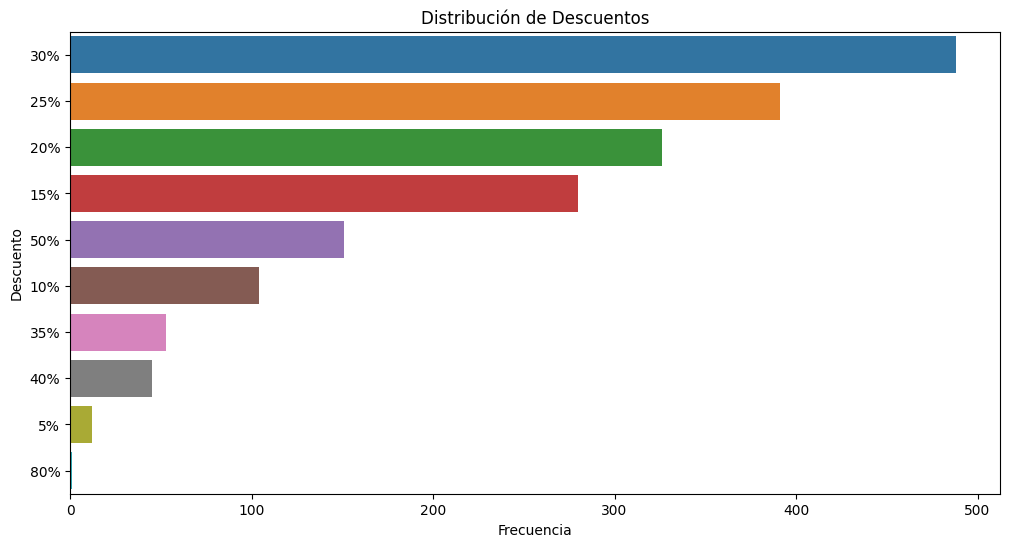

In [13]:
# Gráfico de barras de valores únicos
plt.figure(figsize=(12, 6))
sns.countplot(y='Descuento', data=df, order=df['Descuento'].value_counts().index)
plt.title('Distribución de Descuentos')
plt.xlabel('Frecuencia')
plt.ylabel('Descuento')
plt.show()


In [42]:
# Función para normalizar texto: convertir a minúsculas y eliminar tildes
def normalizar_texto(texto):
    texto = texto.lower()  # Convertir a minúsculas
    texto = ''.join(c for c in unicodedata.normalize('NFD', texto) if unicodedata.category(c) != 'Mn')  # Eliminar tildes
    texto = texto.strip()  # Eliminar espacios adicionales
    return texto

In [43]:
df['Categoria'] = df['Categoria'].apply(normalizar_texto)

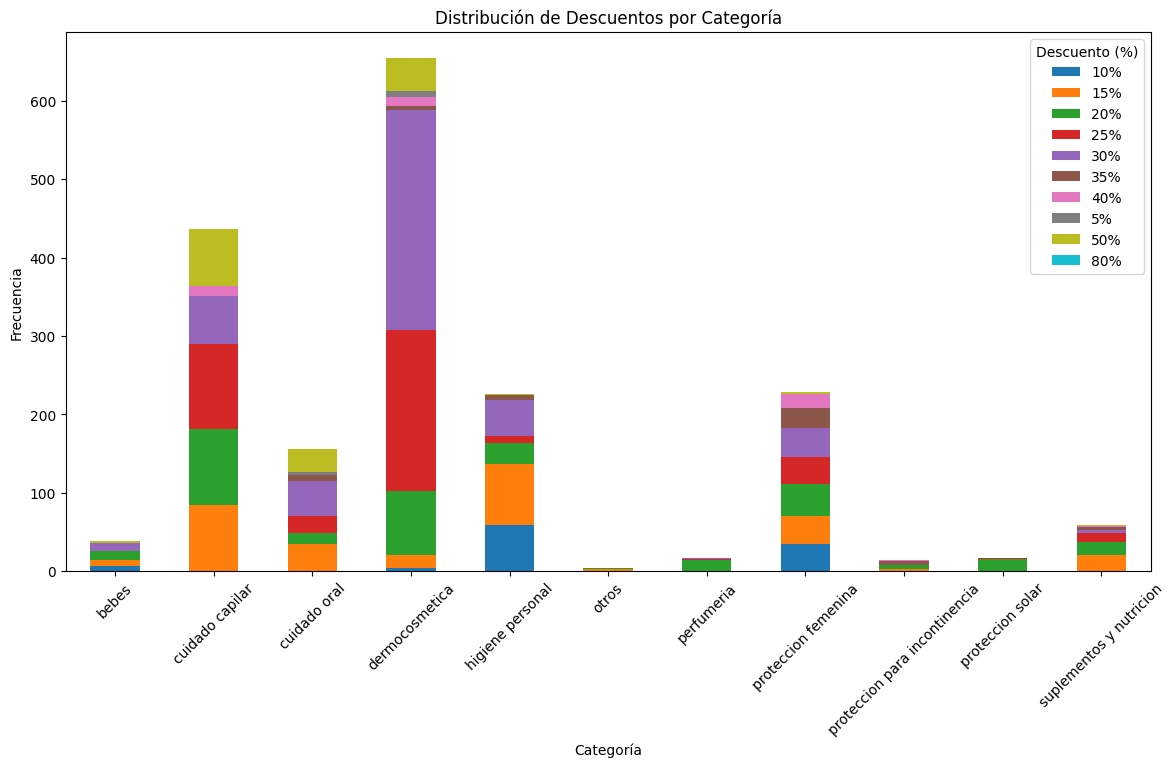

In [72]:
# Contar la frecuencia de cada descuento por categoría
frecuencia_descuentos_categoria = df.groupby('Categoria')['Descuento'].value_counts().unstack().fillna(0)

# Crear un gráfico de barras para visualizar la frecuencia de descuentos por categoría
frecuencia_descuentos_categoria.plot(kind='bar', stacked=True, figsize=(14, 7))
plt.title('Distribución de Descuentos por Categoría')
plt.xlabel('Categoría')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.legend(title='Descuento (%)')
plt.show()

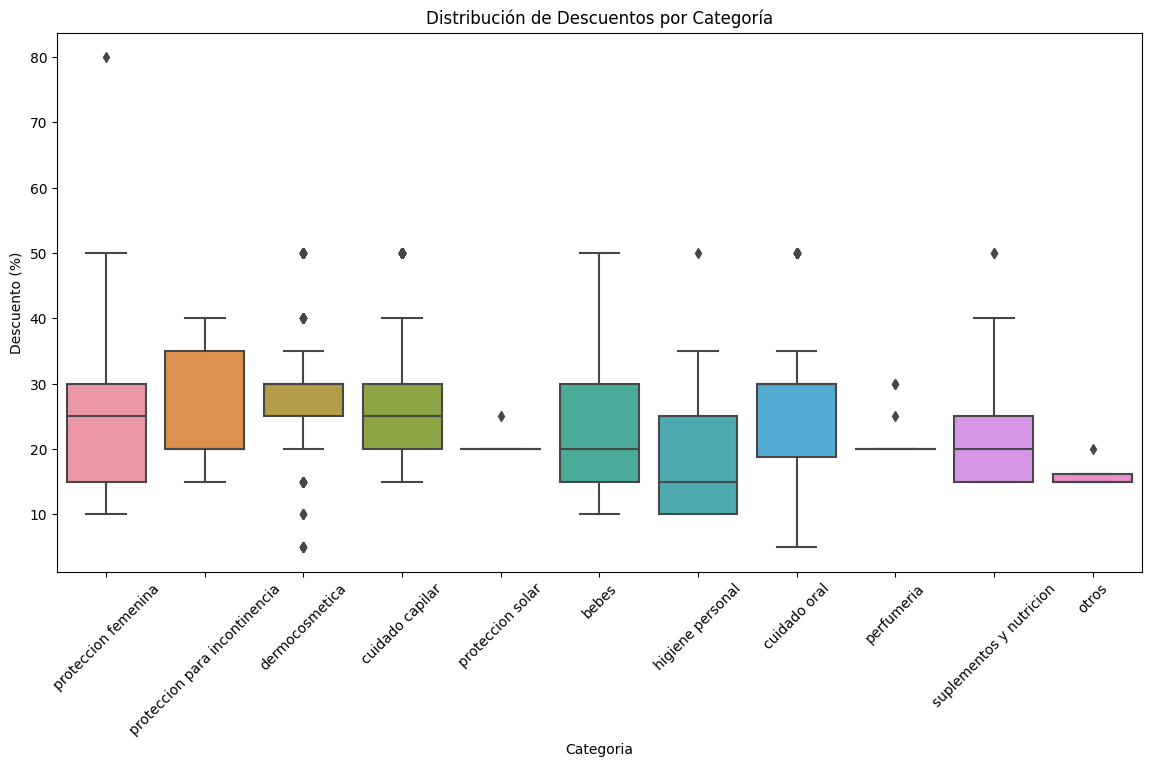

In [76]:
df['descuentos_numeric'] = df['Descuento'].str.replace('%', '').astype(float)
# Crear un gráfico de cajas para visualizar la distribución de descuentos por categoría
plt.figure(figsize=(14, 7))
sns.boxplot(x='Categoria', y='descuentos_numeric', data=df)
plt.title('Distribución de Descuentos por Categoría')
plt.xlabel('Categoria')
plt.ylabel('Descuento (%)')
plt.xticks(rotation=45)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


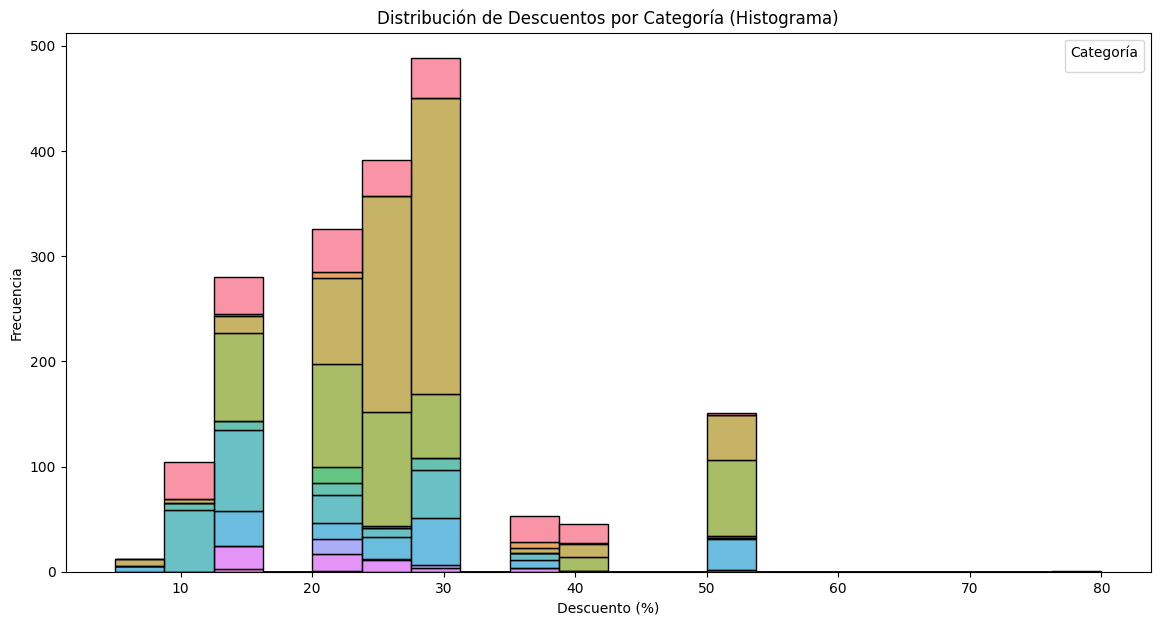

In [77]:
# Crear un histograma de descuentos por categoría
plt.figure(figsize=(14, 7))
sns.histplot(data=df, x='descuentos_numeric', hue='Categoria', multiple='stack', bins=20)
plt.title('Distribución de Descuentos por Categoría (Histograma)')
plt.xlabel('Descuento (%)')
plt.ylabel('Frecuencia')
plt.legend(title='Categoría')
plt.show()


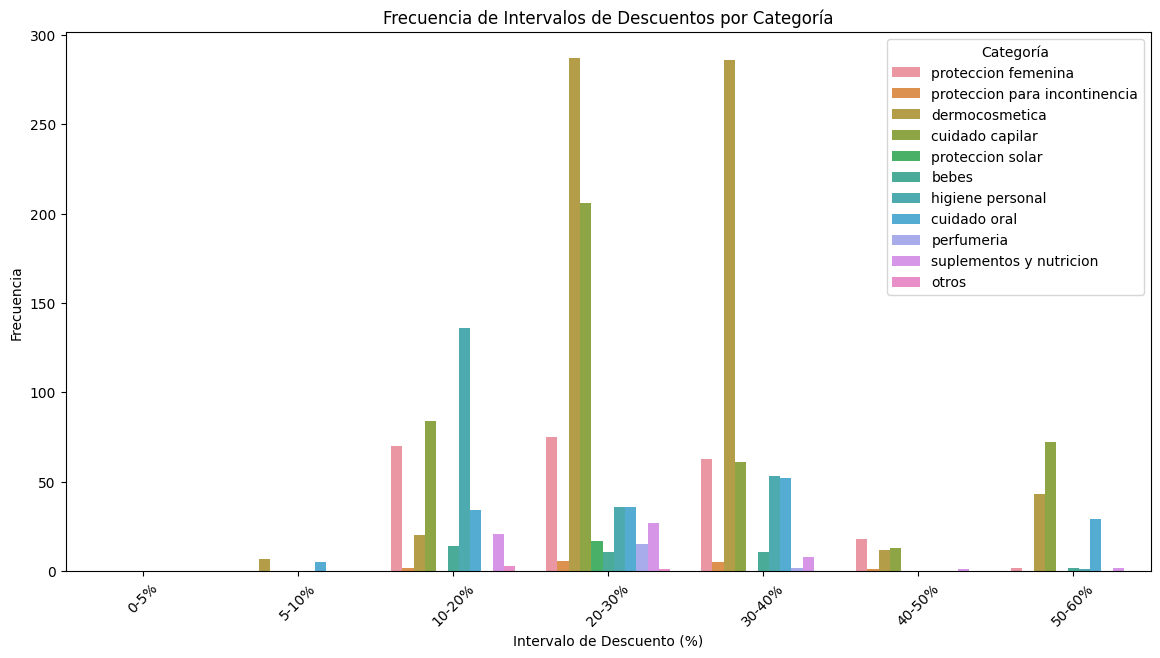

In [78]:
# Definir intervalos de descuento
bins = [0, 5, 10, 20, 30, 40, 50, 60]
labels = ['0-5%', '5-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%']
df['descuentos_binned'] = pd.cut(df['descuentos_numeric'], bins=bins, labels=labels, right=False)

# Crear un gráfico de barras para intervalos de descuentos por categoría
plt.figure(figsize=(14, 7))
sns.countplot(data=df, x='descuentos_binned', hue='Categoria')
plt.title('Frecuencia de Intervalos de Descuentos por Categoría')
plt.xlabel('Intervalo de Descuento (%)')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.legend(title='Categoría')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


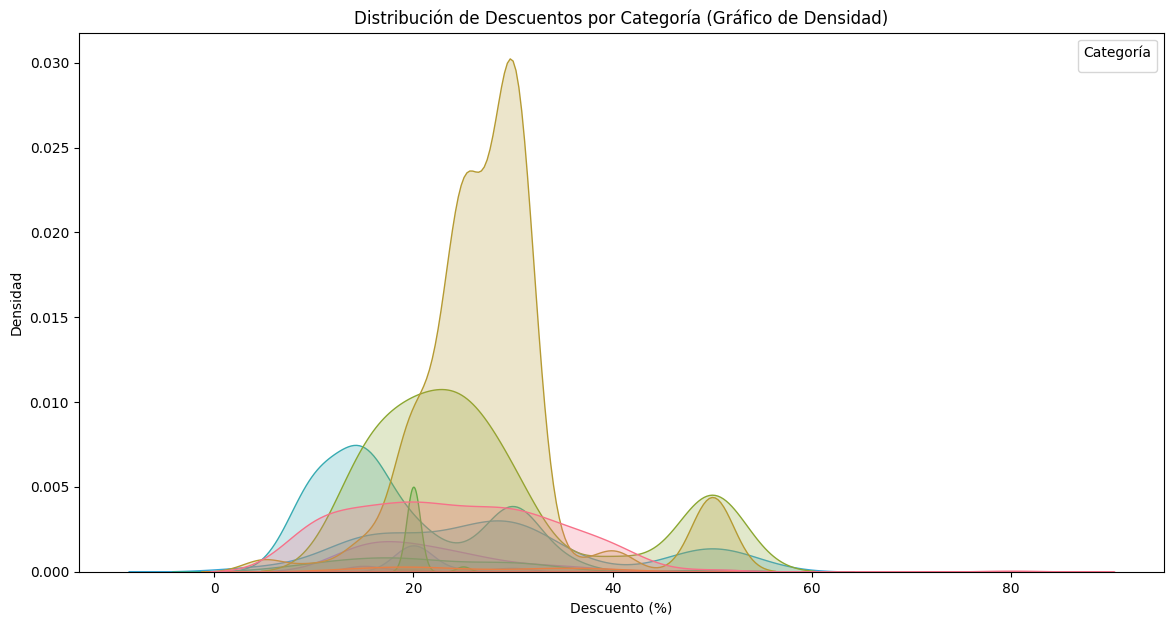

In [79]:
# Crear un gráfico de densidad para visualizar la distribución de descuentos por categoría
plt.figure(figsize=(14, 7))
sns.kdeplot(data=df, x='descuentos_numeric', hue='Categoria', fill=True)
plt.title('Distribución de Descuentos por Categoría (Gráfico de Densidad)')
plt.xlabel('Descuento (%)')
plt.ylabel('Densidad')
plt.legend(title='Categoría')
plt.show()


In [44]:
df['Mes'] = df['Mes'].apply(normalizar_texto)

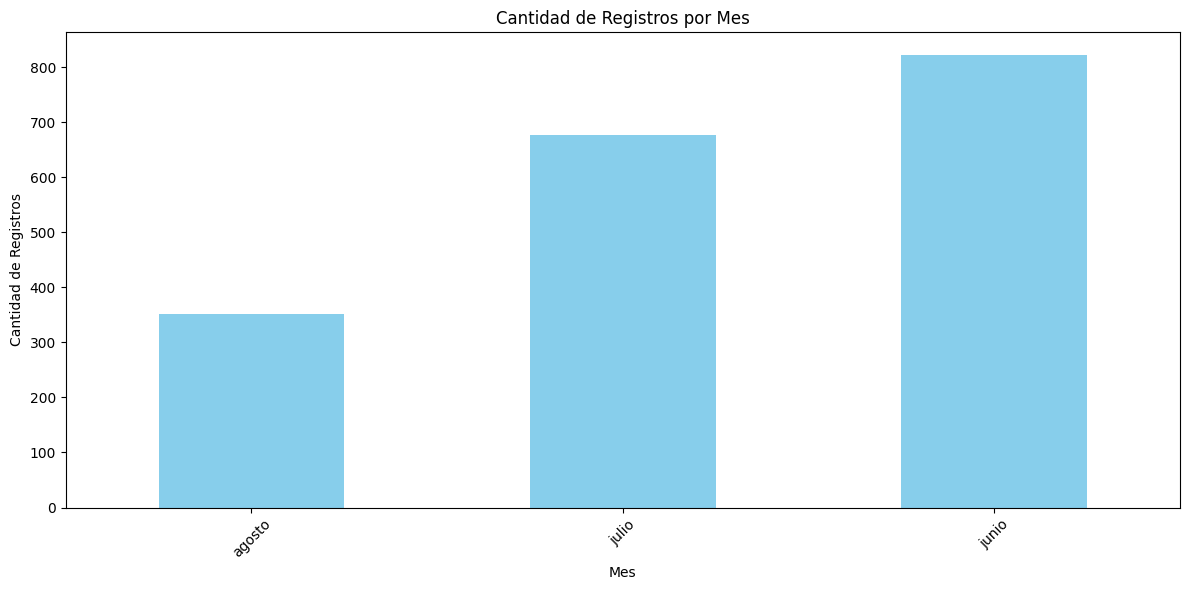

In [82]:
# Contar la cantidad de registros por mes
registros_por_mes = df['Mes'].value_counts().sort_index()

# Crear un gráfico de barras para visualizar la cantidad de registros por mes
plt.figure(figsize=(12, 6))
registros_por_mes.plot(kind='bar', color='skyblue')
plt.title('Cantidad de Registros por Mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad de Registros')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1400x700 with 0 Axes>

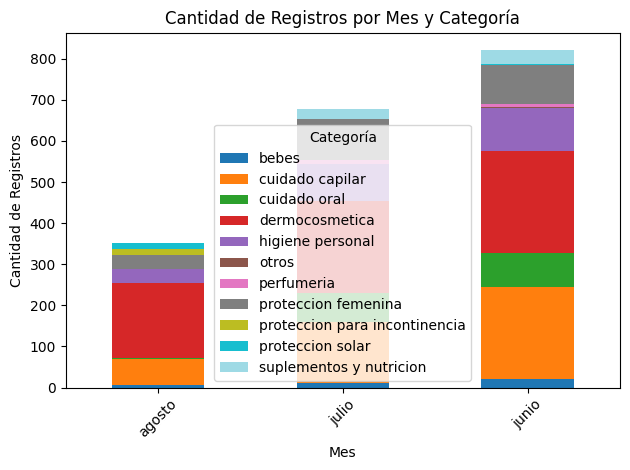

In [83]:
# Contar la cantidad de registros por mes y categoría
contar_por_mes_categoria = df.groupby(['Mes', 'Categoria']).size().unstack(fill_value=0)

# Crear un gráfico de barras apiladas para visualizar la cantidad de registros por mes y categoría
plt.figure(figsize=(14, 7))
contar_por_mes_categoria.plot(kind='bar', stacked=True, colormap='tab20')
plt.title('Cantidad de Registros por Mes y Categoría')
plt.xlabel('Mes')
plt.ylabel('Cantidad de Registros')
plt.xticks(rotation=45)
plt.legend(title='Categoría')
plt.tight_layout()
plt.show()

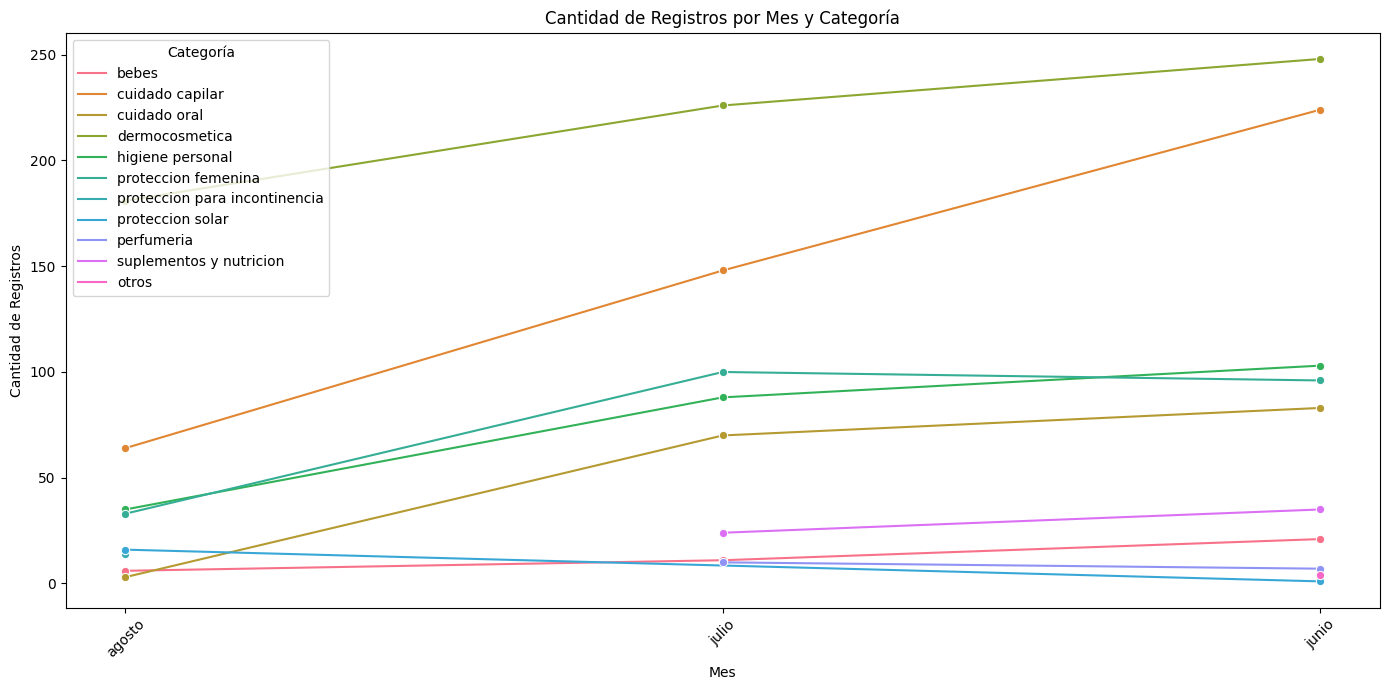

In [85]:
# Contar la cantidad de registros por mes y categoría
contar_por_mes_categoria = df.groupby(['Mes', 'Categoria']).size().reset_index(name='Cantidad')

# Crear un gráfico de líneas para visualizar la cantidad de registros por mes y categoría
plt.figure(figsize=(14, 7))
sns.lineplot(data=contar_por_mes_categoria, x='Mes', y='Cantidad', hue='Categoria', marker='o')
plt.title('Cantidad de Registros por Mes y Categoría')
plt.xlabel('Mes')
plt.ylabel('Cantidad de Registros')
plt.xticks(rotation=45)
plt.legend(title='Categoría')
plt.tight_layout()
plt.show()

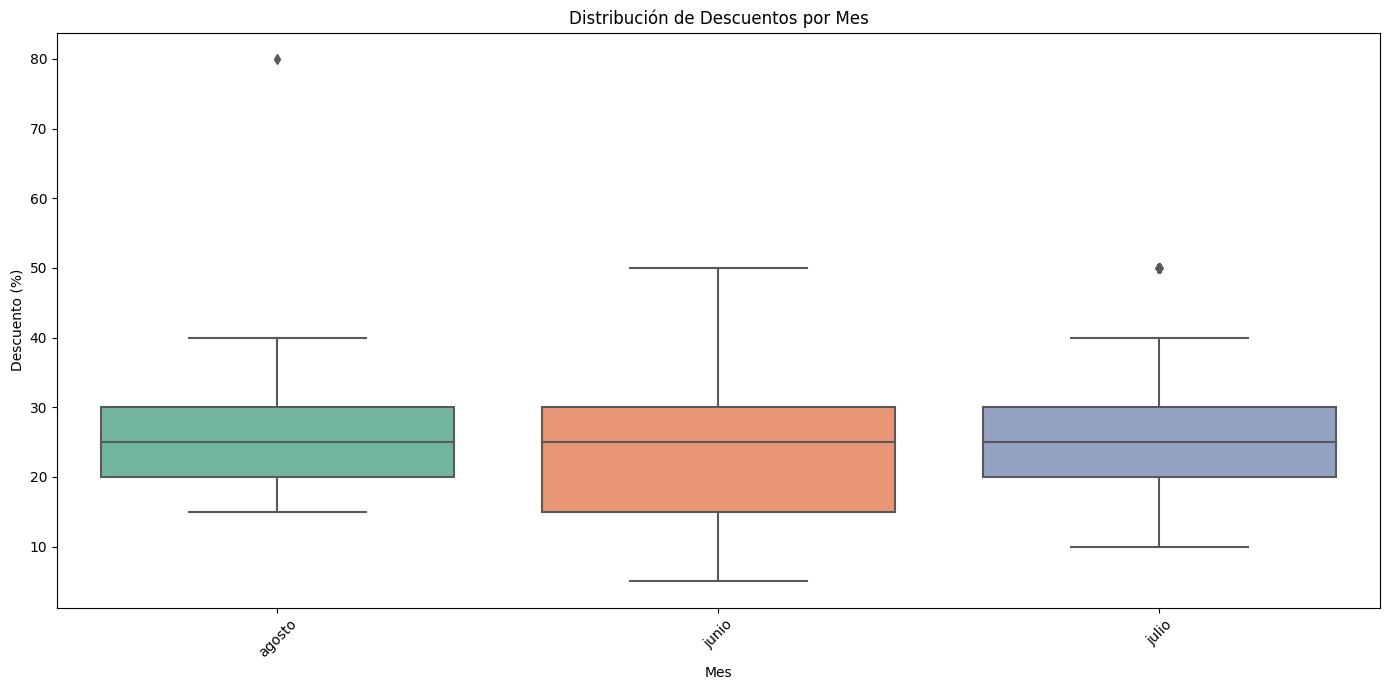

In [16]:
# Asegúrate de que la columna de descuentos esté en formato numérico
df['Descuento'] = df['Descuento'].str.replace('%', '').astype(float)  # Convierte descuentos a números

# Crear un gráfico de cajas para visualizar la distribución de descuentos por mes
plt.figure(figsize=(14, 7))
sns.boxplot(data=df, x='Mes', y='Descuento', palette='Set2')
plt.title('Distribución de Descuentos por Mes')
plt.xlabel('Mes')
plt.ylabel('Descuento (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

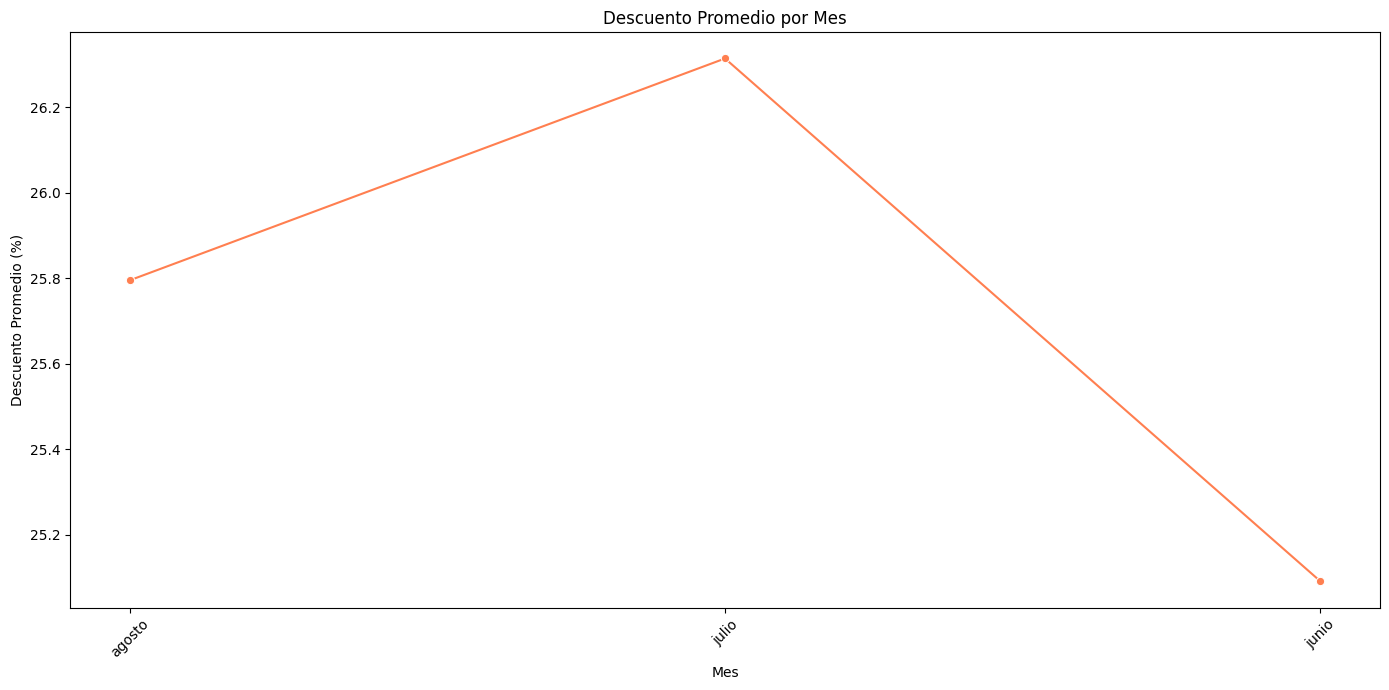

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convertir la columna a tipo string si no lo es
df['Descuento'] = df['Descuento'].astype(str)

# Limpiar la columna de descuentos (eliminar caracteres no deseados)
df['Descuento'] = df['Descuento'].str.replace('%', '', regex=False)  # Elimina el símbolo de porcentaje
df['Descuento'] = df['Descuento'].replace('', '0')  # Reemplaza valores vacíos por 0
df['Descuento'] = pd.to_numeric(df['Descuento'], errors='coerce')  # Convierte a numérico, convierte errores a NaN

# Calcular el descuento promedio por mes
descuento_promedio_por_mes = df.groupby('Mes')['Descuento'].mean().reset_index()

# Crear un gráfico de líneas para visualizar el descuento promedio por mes
plt.figure(figsize=(14, 7))
sns.lineplot(data=descuento_promedio_por_mes, x='Mes', y='Descuento', marker='o', color='coral')
plt.title('Descuento Promedio por Mes')
plt.xlabel('Mes')
plt.ylabel('Descuento Promedio (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


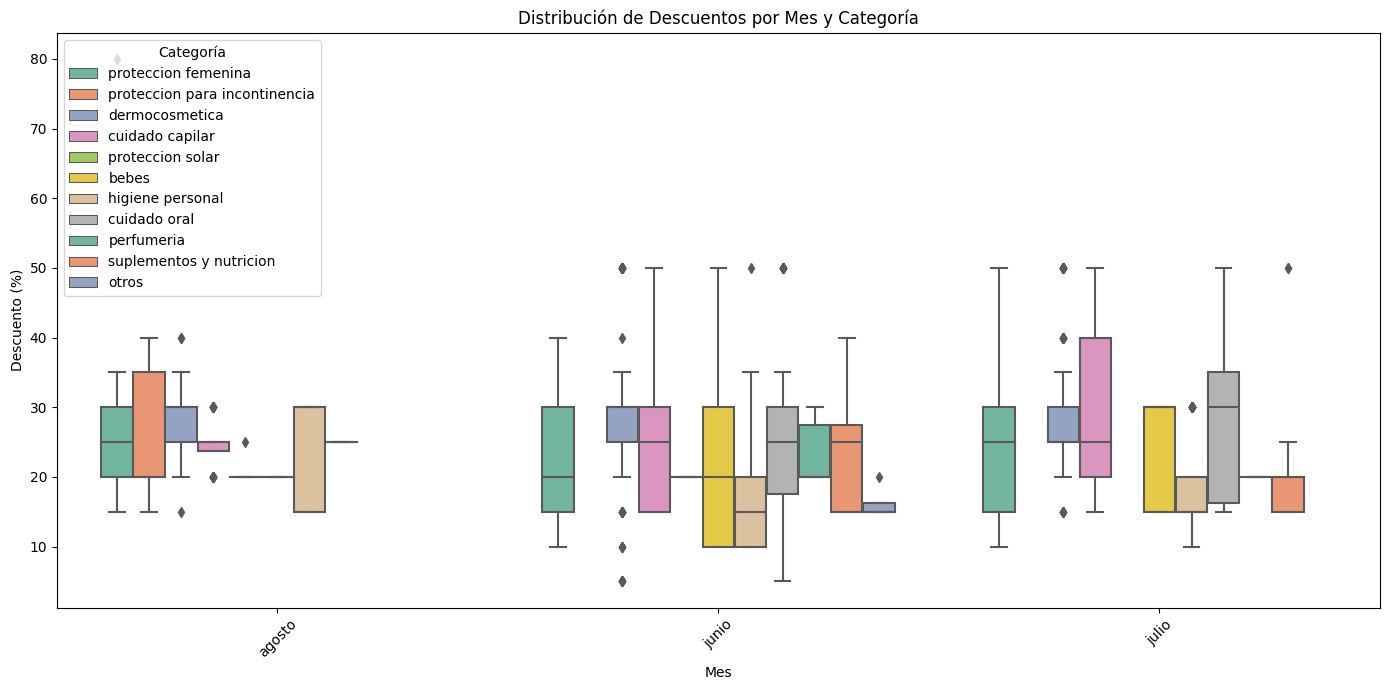

In [99]:
# Convertir descuentos a tipo numérico
# Asegúrate de que 'Descuento' es una columna de tipo string
df['Descuento'] = df['Descuento'].astype(str)

# Limpiar los valores de la columna Descuento
df['Descuento'] = df['Descuento'].str.replace('%', '', regex=False)  # Eliminar el símbolo de porcentaje
df['Descuento'] = df['Descuento'].replace('', '0')  # Reemplazar valores vacíos por 0
df['Descuento'] = pd.to_numeric(df['Descuento'], errors='coerce')  # Convertir a numérico, convertir errores a NaN

plt.figure(figsize=(14, 7))
sns.boxplot(data=df, x='Mes', y='Descuento', hue='Categoria', palette='Set2')
plt.title('Distribución de Descuentos por Mes y Categoría')
plt.xlabel('Mes')
plt.ylabel('Descuento (%)')
plt.xticks(rotation=45)
plt.legend(title='Categoría')
plt.tight_layout()
plt.show()


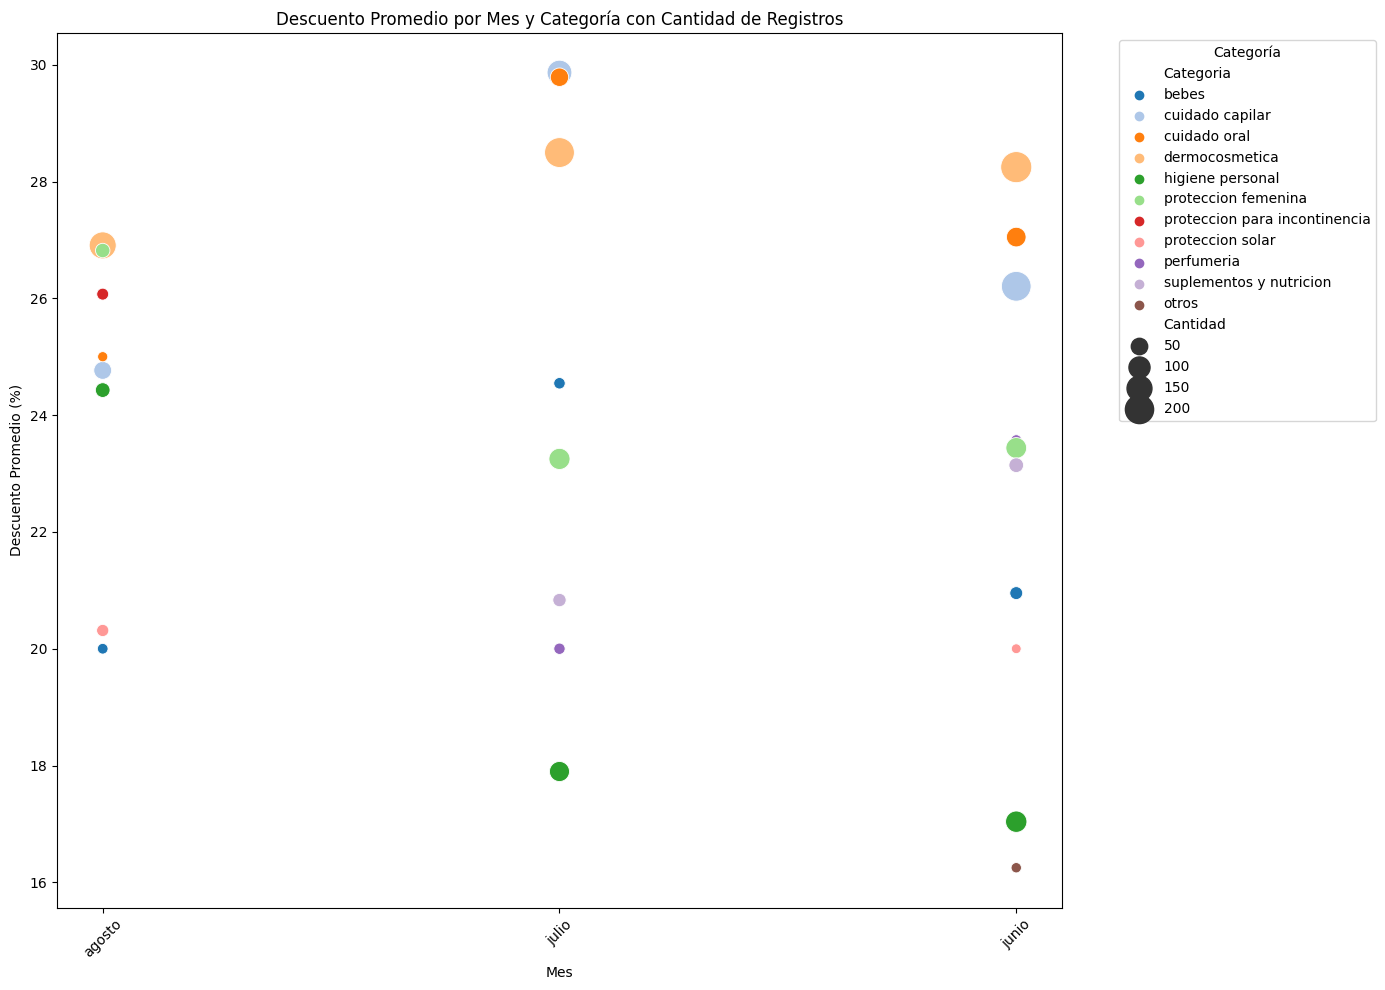

In [101]:
# Calcular el descuento promedio por mes y categoría
descuento_promedio_por_mes_categoria = df.groupby(['Mes', 'Categoria']).agg({'Descuento': 'mean', 'EAN NUEVO': 'size'}).reset_index()
descuento_promedio_por_mes_categoria.rename(columns={'EAN NUEVO': 'Cantidad'}, inplace=True)

# Crear un gráfico de burbujas
plt.figure(figsize=(14, 10))
sns.scatterplot(data=descuento_promedio_por_mes_categoria, x='Mes', y='Descuento', size='Cantidad', hue='Categoria', palette='tab20', sizes=(50, 500))
plt.title('Descuento Promedio por Mes y Categoría con Cantidad de Registros')
plt.xlabel('Mes')
plt.ylabel('Descuento Promedio (%)')
plt.xticks(rotation=45)
plt.legend(title='Categoría', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

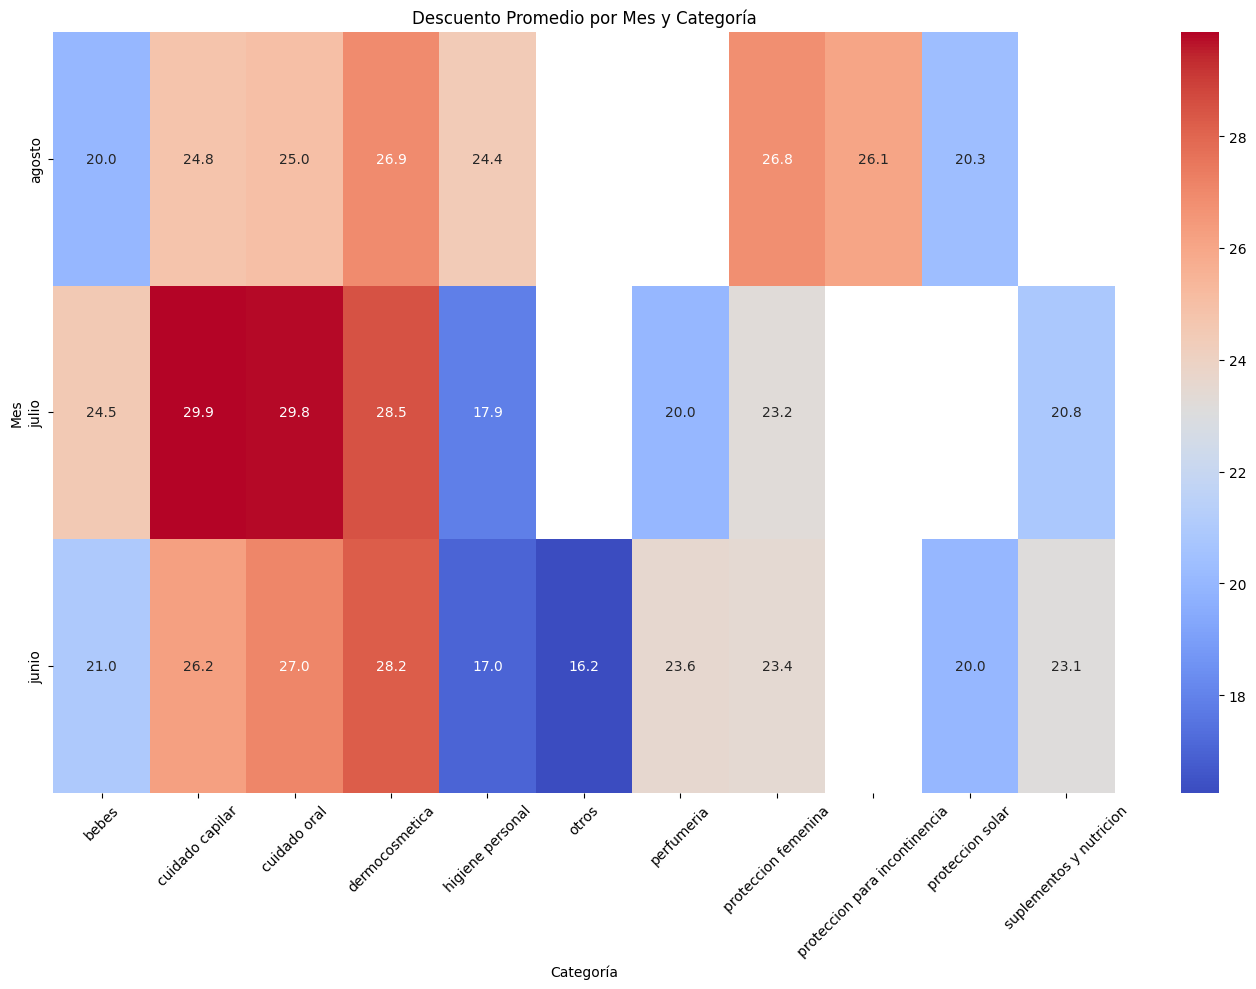

In [102]:
# Calcular la media de descuentos por mes y categoría
descuento_promedio_por_mes_categoria = df.pivot_table(index='Mes', columns='Categoria', values='Descuento', aggfunc='mean')

# Crear un gráfico de calor
plt.figure(figsize=(14, 10))
sns.heatmap(descuento_promedio_por_mes_categoria, annot=True, cmap='coolwarm', fmt='.1f')
plt.title('Descuento Promedio por Mes y Categoría')
plt.xlabel('Categoría')
plt.ylabel('Mes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [45]:
import re

marcas = {
    'nos': 'Nosotras',
    'veet': 'Veet',
    'ky': 'KY',
    'derma': 'Dermaglós',
    'hs': 'Head & Shoulders',
    'nivea': 'Nivea',
    'pnt': 'Pantene',
    'ptn': 'Pantene',
    'john': 'Johnson',
    'pantene': 'Pantene',
    'venus': 'Venus',
    'pb3': 'Gilette',
    'mach': 'Gilette',
    'm3': 'Gilette',
    'gil': 'Gilette',
    'always': 'Always',
    'aveno': 'Aveno',
    'atrix': 'Atrix',
    'babelito': 'Babelito',
    'bagovit': 'Bagovit',
    'bucal': 'Bucaltac',
    'bushi': 'Bushi',
    'listerine': 'Listerine',
    'hipoglos': 'Hipoglos',
    'neu': 'Neutrogena',
    'tena': 'Tena',
    'calipso': 'Calipso',
    'colgate': 'Colgate',
    'pampers': 'Pampers',
    'espadol': 'Espadol',
    'sensodyne': 'Sensodyne',
    'oral': 'Oral-B',
    'otowil': 'Otowil',
    'kotex': 'Kotex',
    'huggies': 'Huggies',
    'oreal': 'Loreal',
    'siempre': 'Siempre Libre',
    'fructis': 'Fructis',
    'elv': 'Loreal',
    'dove': 'Dove',
    'axe': 'Axe',
    'rexona': 'Rexona',
    'lux': 'Lux',
    'cicatricure': 'Cicatricure',
    'protex': 'Protex',
    'roby': 'Roby',
    'adermicina': 'Adermicina',
    'caladryl': 'Caladryl',
    'evagina': 'Evagina',
    'ena': 'Enaccion',
    'truemade': 'True Made',
    'lomecan': 'Lomecan'

}

In [46]:
# Función para buscar la marca en la descripción
def extraer_marca(descripcion):
    patron = r'(' + '|'.join(marcas.keys()) + r')'
    match = re.search(patron, descripcion, re.IGNORECASE)
    if match:
        alias = match.group(1).lower()  
        return marcas[alias]  
    return None  

df['Marca'] = df['DESCRIPCIÓN'].apply(extraer_marca)

print(df[['DESCRIPCIÓN', 'Marca']])

                                            DESCRIPCIÓN     Marca
0              TOAL. NOSOTRAS CLASICA CUR V C/CALE 30X8  Nosotras
1            TOALLA NOSOTRAS CLASICA CUR V C/CALE 15X16  Nosotras
2            TOALLA NOSOTRAS INVISIBLE CUR V C/CALE30X8  Nosotras
3              TOALLA ULTRA INV RAPISEC CUR V 15X14 ARG      None
4                   TOAL. NOSOTRAS BN TELA CURVMAX 24X8  Nosotras
...                                                 ...       ...
1978       VEET SENSIBLE CUERPO BANDA DEPILAT X6 DOBLES      Veet
1979  VEET BANDAS DEPILAT.AXILAS/BIKINI PIEL SENSIBL...      Veet
1980         VEET BANDAS AXILAS/BIKINI P/NORMAL ENV x 8      Veet
1981                      KY GEL LUBRICANTE INTIMO X100        KY
1982                                  KY JELLY ENV x 50        KY

[1851 rows x 2 columns]


In [19]:
# Para ver las marcas que faltan:
sin_marca = df[df['Marca'].isnull()]

for index, row in sin_marca.iterrows():
    print(f"Descripción: {row['DESCRIPCIÓN']}, Marca: {row['Marca']}")

Descripción: TOALLA ULTRA INV RAPISEC CUR V 15X14 ARG, Marca: None
Descripción: TAMPON DIGITAL REGULAR 12X8 SEDA ARG, Marca: None
Descripción: Q10 Serum Doble Acción Anti Edad, Marca: None
Descripción: BAG. ABSORCION 1 MIN SPY CONT. X 170 ML, Marca: None
Descripción: BAG.BRONC.PROGR.SPRAY CONT. X 150 ML, Marca: None
Descripción: PRURISEDAN CREMA x 30 GR, Marca: None
Descripción: PRURISEDAN LOCIÓN INCOLORA X 60 ML, Marca: None
Descripción: PRURISEDAN POLVO 60 GRS, Marca: None
Descripción: BSC 1181 PINZA DEPILAR LUJO DOBLE MATE ENV x 1, Marca: None
Descripción: BSC 1509 PINZA DEPILAR C/REMOVEDOR PUNTOS NEGROS ENV x 1, Marca: None
Descripción: BSC 2170 GUANTE EXFOLIANTES P/CUERPO BLANCO ENV x 1, Marca: None
Descripción: BSC 5022 SIGNATURE BROCHA MAQUILLAJE ENV x 1, Marca: None
Descripción: BSC 1028 ALICATE P/UÑAS INCLINADO CUCHILLA CURVA ENV x 1, Marca: None
Descripción: Gel Fijación Fuerte Ortiga Concentrado x 160 g, Marca: None
Descripción: Shampoo Ortiga-Caspa Concentrado, Marca: None


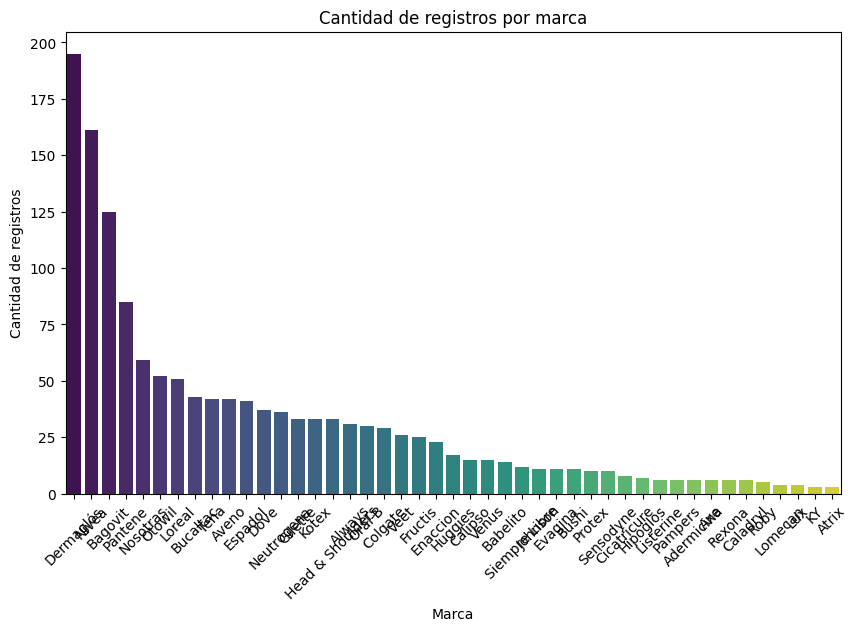

In [47]:
conteo_marcas = df['Marca'].value_counts()
# Gráfico de barras con Seaborn
plt.figure(figsize=(10,6))
sns.barplot(x=conteo_marcas.index, y=conteo_marcas.values, palette='viridis')
plt.title('Cantidad de registros por marca')
plt.xlabel('Marca')
plt.ylabel('Cantidad de registros')
plt.xticks(rotation=45)
plt.show()


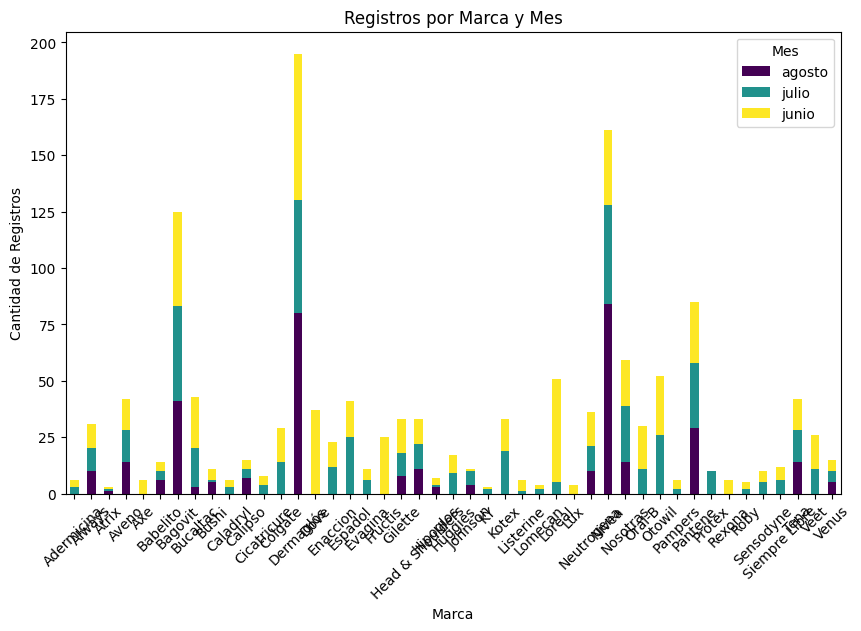

In [48]:
# Agrupar los datos por 'marca' y 'mes' y contar los registros
conteo = df.groupby(['Marca', 'Mes']).size().unstack(fill_value=0)

# Gráfico de barras apiladas
conteo.plot(kind='bar', stacked=True, figsize=(10,6), colormap='viridis')

# Configurar títulos y etiquetas
plt.title('Registros por Marca y Mes')
plt.xlabel('Marca')
plt.ylabel('Cantidad de Registros')
plt.xticks(rotation=45)
plt.legend(title='Mes')
plt.show()


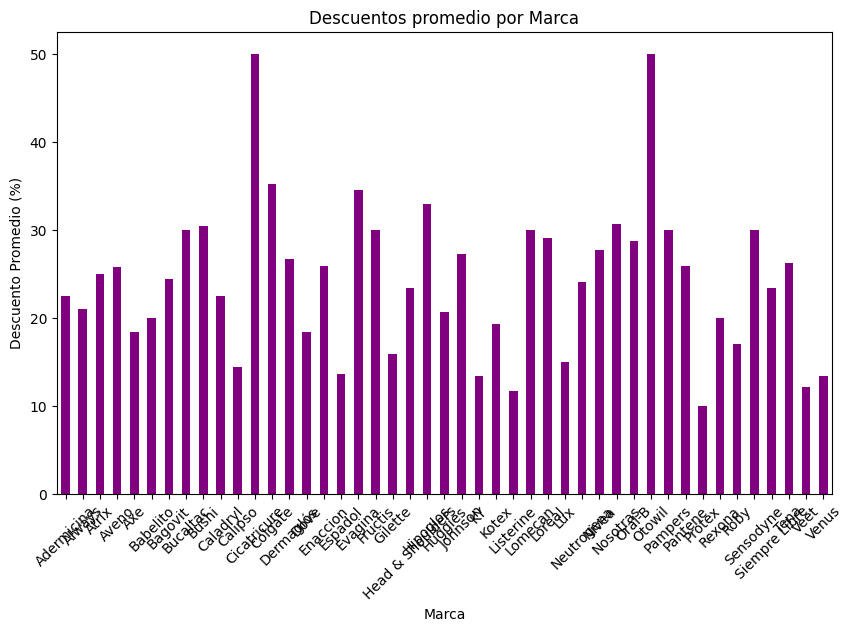

In [51]:
import matplotlib.pyplot as plt

# Agrupar por marca y calcular el promedio de descuentos
descuentos_marca = df.groupby('Marca')['descuento_num'].mean()

# Crear el gráfico de barras
descuentos_marca.plot(kind='bar', figsize=(10,6), color='purple')

# Configurar títulos y etiquetas
plt.title('Descuentos promedio por Marca')
plt.xlabel('Marca')
plt.ylabel('Descuento Promedio (%)')
plt.xticks(rotation=45)
plt.show()


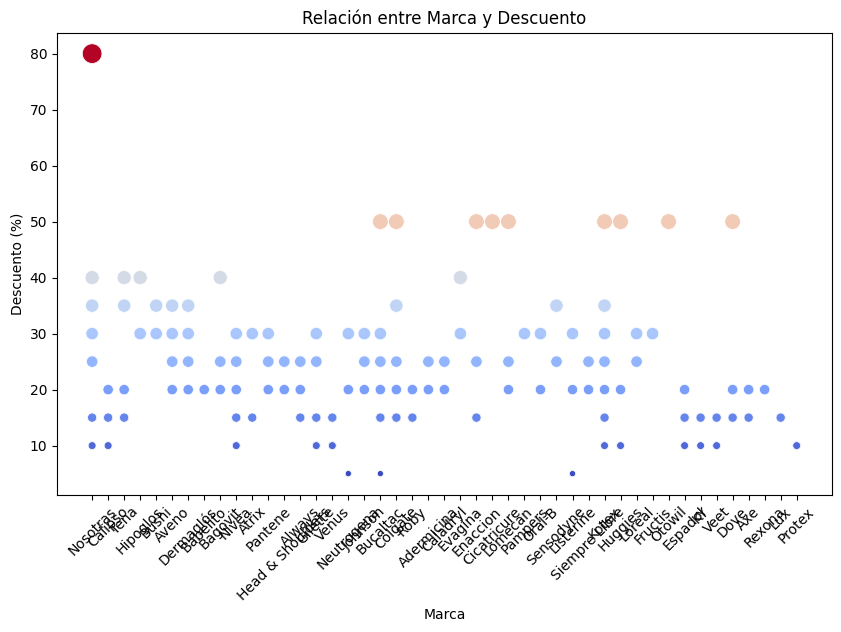

In [52]:
import seaborn as sns

# Crear el gráfico de burbujas (scatter plot)
plt.figure(figsize=(10,6))
sns.scatterplot(x='Marca', y='descuento_num', size='descuento_num', data=df, sizes=(20, 200), hue='descuento_num', palette='coolwarm', legend=False)

# Configurar títulos y etiquetas
plt.title('Relación entre Marca y Descuento')
plt.xlabel('Marca')
plt.ylabel('Descuento (%)')
plt.xticks(rotation=45)
plt.show()
